In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
sns.set_style('whitegrid')

In [4]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# set time to index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

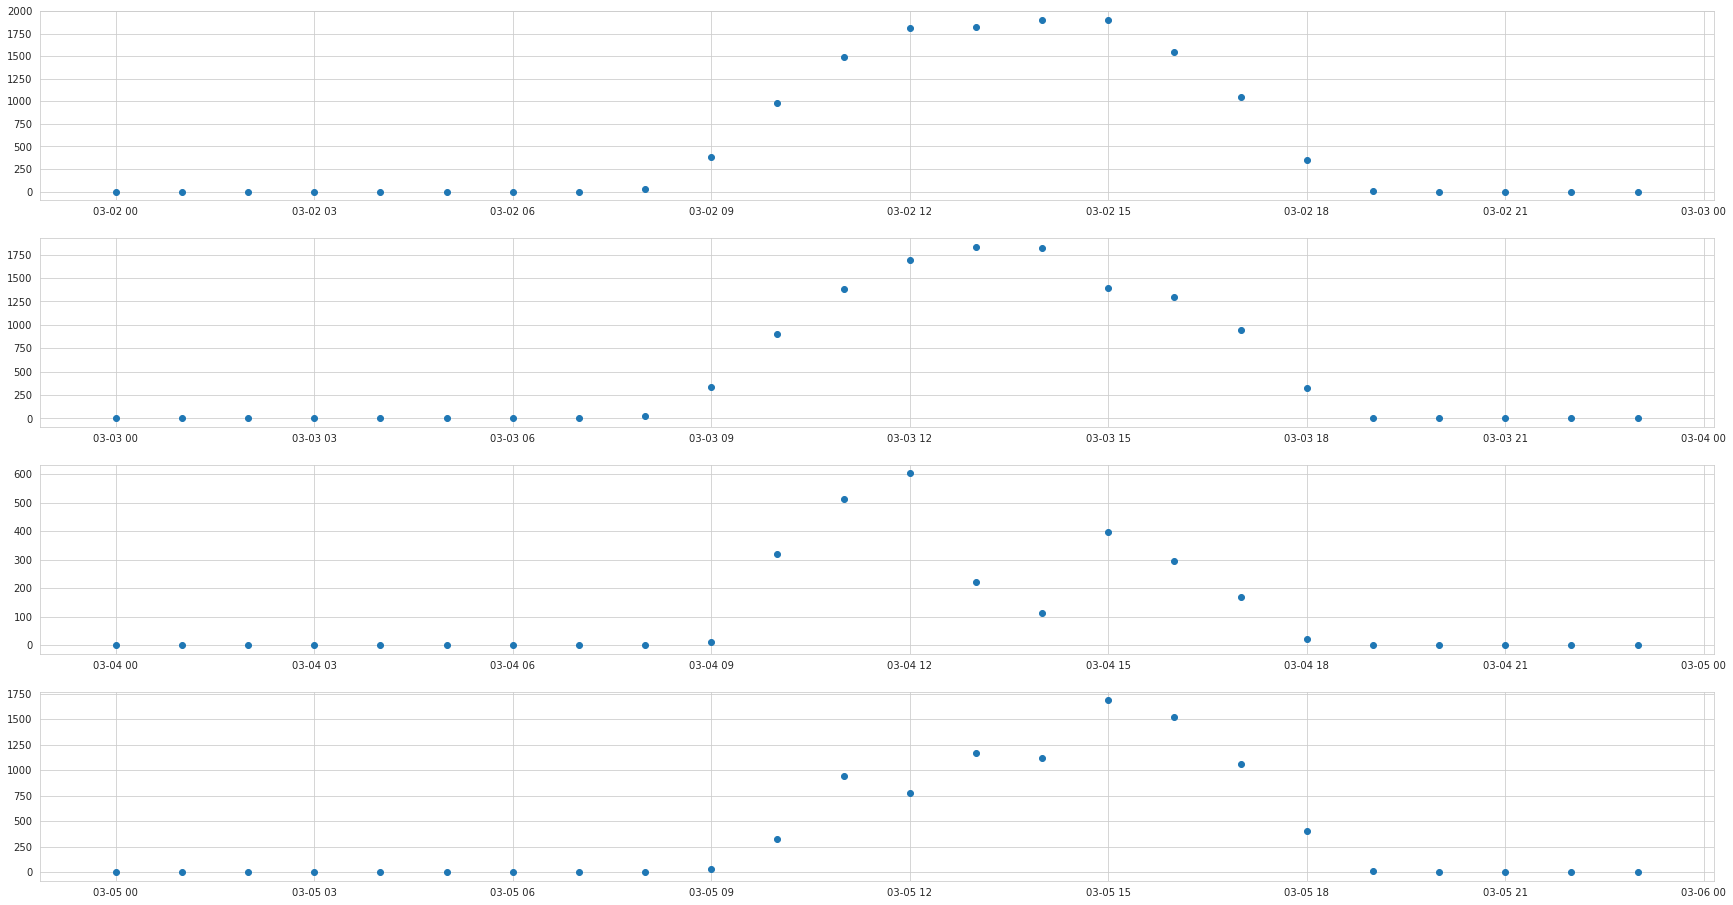

In [14]:
# investigate peaks
N = 4
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    i = 24*n
    dangjin_sample = dangjin_data.iloc[i:i+24]
    ax[n].scatter(dangjin_sample.index, dangjin_sample['dangjin_sum'])

# 주로 12~15시에 분포

## Only peaks

In [95]:
# peak (1 row with max value)
x_peaks_n_row = dangjin_data.shape[0] // 24
peaks_list = []

for i in range(x_peaks_n_row):
    # slicing 1 day
    dangjin_sample = dangjin_data.iloc[i*24:i*24+24]
    # find peak
    peak = dangjin_sample['dangjin_sum'].argmax()
    # only using the peak hour
    peaks_list.append(dangjin_sample.iloc[peak])

peaks = pd.concat(peaks_list, axis=1).transpose()

In [6]:
# peaktime (12시-15시)

dangjin_data['time'] = dangjin_data.index.hour
peaktimes = dangjin_data.loc[dangjin_data['time'].isin([12,13,14,15])]

## Selecting columns

In [8]:
x_cols = ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst','Day_cos','Day_sin','Year_cos', 'Year_sin']
y_cols = ['dangjin_sum']

## Modeling (rf)
: check result in random_forest_experiment.ipynb

In [73]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [74]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).sum(axis=0)

In [96]:
# peak
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=200, min_samples_leaf=11)
predict, test_y = validate(model, peaks, x_cols, y_cols)

test_y['predict'] = predict
with open('peak_prediction.pkl', 'wb') as f:
    pickle.dump(test_y, f)

<ipython-input-73-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


In [94]:
# peaktime
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=200, min_samples_leaf=11)
predict, test_y = validate(model, peaktimes, x_cols, y_cols)

test_y['predict'] = predict
with open('peaktime_prediction_rf.pkl', 'wb') as f:
    pickle.dump(test_y, f)

<ipython-input-73-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


## Modeling (nn) - significant underfitting

In [90]:
def validate_keras(model, data, x_cols, y_cols, test_size=0.2):
    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # normaize
    x = (x - x.mean(axis=0)) / x.std(axis=0)

    y_mean = y.mean(axis=0).iloc[0] # as scala
    y_std = y.std(axis=0).iloc[0] # as scala
    y = (y - y_mean) / y_std


    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit
    model.fit(x=train_x, y=train_y, validation_split=0.2, epochs=8, batch_size=2)

    # predict
    predict = model.predict(test_x)
    predict = predict * y_std + y_mean
    test_y = test_y * y_std + y_mean

    return predict, test_y

In [91]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(21, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='relu'),
    layers.Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='huber')

predict, test_y = validate_keras(model, peaktimes, x_cols, y_cols, test_size=0.2)

Epoch 1/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3955 - val_loss: 0.3137
Epoch 2/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3702 - val_loss: 0.2994
Epoch 3/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3423 - val_loss: 0.2860
Epoch 4/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3393 - val_loss: 0.2815
Epoch 5/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3602 - val_loss: 0.2775
Epoch 6/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3418 - val_loss: 0.2791
Epoch 7/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3188 - val_loss: 0.2790
Epoch 8/8
1366/1366 [==============================] - 4s 3ms/step - loss: 0.3133 - val_loss: 0.2725


In [92]:
# pickle
test_y['predict'] = predict
with open('peaktime_prediction_keras.pkl', 'wb') as f:
    pickle.dump(test_y, f)

## HP optimization(rf)

In [58]:
hps = np.arange(8,16)
ITER = 3
err_by_hp = {x:[] for x in hps}

for x in hps:
    for _ in range(ITER):
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=x)
        predict, test_y = validate(model, peaks, x_cols, y_cols)
        err_by_hp[x].append(evaluate(predict, test_y))
        
err_by_hp = pd.DataFrame(err_by_hp)

<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected

In [62]:
err_by_hp

,8,9,10,11,12,13,14,15
0,46544.607434,45615.622107,46086.653521,45695.491697,46032.777126,45885.624229,46207.307470,46437.259692
1,46461.615344,45660.949988,45683.557390,45040.405258,46410.331730,45813.434912,46148.073741,45363.520000
2,46549.431341,46580.677306,46333.529428,46522.459780,45393.808687,45950.987085,46207.705740,45543.041950
